# Programación dinámica probabilísticos de horizontes infinito

## Ejemplo:
Juan vende cervezas artesanales de Lunes a Viernes.
- $c:=$Las compra por\$300 cada una.
- $k:=$ Costo de hacer un pedido =\$100
- $v:=$Las vende por\$1.500 cada una.
- $h:= $ Costo de almacenamiento=\$200
- La demanda es uniforme de $a$ a $b$
    - a=0
    - b=3
- $S:=$La capacidad maxima de inventario = 4 

    - Tomar en cuenta que esta es una restricción que define el horizonte de decisiones para la cantidad de inventario $d$ a comprar, según el estado $i$ de inventario.
    $0\leq d \leq S-i $

- Venta perdida por producto $= v−c$


## ¿Ayude a decidir a Juan cuánto comprar, según el inventario $i$ que tenga al comienzo de cada periodo?

In [1]:
import numpy as np
import pandas as pd
from numpy import random
import collections
import time
from plotnine import *

Como se conoce la distribución de la demanda y esta tiene un comportamiento discreto, cada escenario de demanda posee la siguiente probabilidad de ocurrencia.

\begin{equation*}
P_{demanda}=
\dfrac{1}{b-a+1}
\end{equation*}

### Matriz de probabilidades
En el la teoría las probabilidades estan representadas de la siguiente forma:

\begin{equation*}
P(j|i,d)
\end{equation*}

$j$ el estado(nivel de inventario) siguiente, dada el estado(nivel de inventario) inicial $i$ y la decisión $d$ (cantidad de inventario a comprar) tomada. 

Debido a que los resultados del problema se basan principalmente en el nivel de inventario y la desiciones son basicamente a que nivel de inventario superior moverse, la estructura en código de este problema se aprovecha de esta particularidad. 

La matriz de probabilidades se estructura de la siguiente forma

`Prob[i][j]`:= Es la probalidad de que el inventario i pase al nivel de inventario j en el siguente periodo, dado que no se realizo ninguna compra (d=0)

Notar que si se realiza alguna compra $d$ el paso para obtener $P(j|i,d)$ es simplemente  
       
   $P(j|i,d)= $    `Prob[ i+d ][ j ]`

In [2]:
def matriz_prob(S,prob_dist):
    prob = np.zeros([S+1,S+1])  #Creamos Matriz de ceros
    for i in range(S+1):        #Posibles estados iniciales
        for j in range(i,-1,-1):    #Estados de destino
            if sum(prob[i])<1:
                prob[i,j] = prob_dist
        prob[i,0] = 1 - sum(prob[i,1:])
    return prob

Notar que basicamente las probabilidades planteadas, son en base a como disminuye el nivel de inventario segun la demanda que tiene. Es por ello que cuando se posee una demanda superior al nivel de inventario su probabilidad se acumula en $j=0$ 


## Expected Reward


Tomando en cuenta la particularidad, mencionada anteriormente, el reward solo contemplará la decisión de no comprar nada de inventario ($d=0$). Por tanto es la utiliad esperada, segun el nivel de inventario $i$ y en las ecuaciones siguientes se agregarán los costos asociados a la compra $d$. 

Es por ello que para almacenar el expected reward, se utilizará al siguiente estructura:
    
`reward[i]` := el expected reward ante un nivel de inventario $i$, al no realizar una compra $(d=0)$.
    
    
`reward[ i ]` = 
\begin{align*}
\sum_{Dem=a}^b P_{Dem}\cdot( &\\ &
v\cdot\min\{Dem,i\} \\&
-(v-c)\cdot\max\{Dem-i,0\}\\& 
-(h)\cdot\max\{i-Dem,0\} )
\end{align*}


Entonces para calcular el Expected Reward teórico $r_{i,d}$ se realizará de la siguiente forma, dentro de las funciones siguientes.

$r_{i,d}=$ `reward[i+d]`  $-c\cdot d $  $-k\cdot\min\{d,0\} $


In [3]:
def reward_esperado(prob_dist,S,d_minima,d_maxima,V,H,C):
    reward=np.zeros(S+1)    #Creamos vector de beneficios de t
    for i in range(S+1):    #Recorremos todos los posibles inventarios
        r=0                 #Iniciamos en cero para cada nivel de inventario
        for dem in range(d_minima,d_maxima+1):#Recorremos todos las demandas posibles
            p_d = prob_dist # Probabilidad demanda 
            r_dem = V*min(dem,i)  # Vendemos el minimo entre lo que se tiene y la demanda
            if(dem>=i): #Si llega más demanda de la que se puede cubrir
                r_dem -= (V-C)*(dem-i) #Costo oportunidad
            else:       #Queda inventario para el periodo siguiente
                r_dem -= (H)*(i-dem)   #Costo de almacenar 
            r+= p_d*(r_dem)            
            #Suma de todos los beneficios por la probabilidad de la demanda de un nivel de inventario i
        reward[i]=r #Beneficio esperado nivel de inventario i
    return reward

## Value Determination Equations

\begin{equation}
    g+V_{\delta}(i) = r_{i,\delta(i)} +  \sum_{j=0}^{S} p(j|i,\delta(i))V_{\delta}(j)
\end{equation}

Como ya fue explicado antes, el $r_{i,\delta(i)}$ (o $\sim r_{i,d})$ se debe calcular en esta parte del código, para aprovecharse de la estructura. Además del $p(j|i,\delta(i))$ (o $\sim p(j|i,d) $).

Basicamente la función a continuación uno le entrega un vector de decisiones $D$ o `decisions` cual en cada valor $d_i$ (`decisions[i]`)refleja la cantidad de cervezas a comprar dado el nivel de inventario $i$

Para solucionar el sistema de ecuaciones, las ecuaciones deben plantearse de forma matricial, donde se posee una matriz $A_{S+2\times S+2}$ con las variables ($g$ ; $V_{\delta}(i), \forall i \in \{0,\dots S\} $) y una matriz con el valor constante $B_{S+2\times1}$. Donde cada fila $i$, salvo la ultima, posee la siguiente ecuación .

\begin{equation*}
A_i=g + V_{\delta}(i) -  \sum_{j=0}^{S} p(j|i,\delta(i))V_{\delta}(j)
\end{equation*}

\begin{equation*}
B_i= r_{i,\delta(i)} 
\end{equation*}

La ultima fila de $A$, debido al problema es $A_{S+2,}=V_{\delta}(S)$ y la ultima fila de $B$ es igual a 0. De esta forma, se puede solucionar el sistema de ecuaciones.





In [4]:
#funcion para obtener el valor de la ecuaciones
#No quitamos los print por si quieren hacerlo con menos casos y observar los calculos
def Value_Determination_Equations(decisions,prob,descuento,costo,revenues,S,K):
    L=len(decisions)
    aux=np.zeros([L,L]) #Creamos Matriz combinación de desiciones
    B=np.zeros(L)       #Creamos Lado derecho del sistema de ecuaciones
    for i in range(L):  #Recorremos todas las decisiones
        cant_comprada_i=decisions[i] #Almacenamos cuanto fue la decision
        if cant_comprada_i>0: #Verificamos si decidio comprar
        #Juan decide comprar mas cerveza.
            if(cant_comprada_i+i<=S):
            # La compra más el inventario debe ser menor a Cap max
                B[i] =  revenues[cant_comprada_i+i]#beneficio del nuevo nivel de inventario
                B[i] -= costo*(cant_comprada_i)    #Costo de cant cervezas compradas
                B[i] -= K                          #Costo de hacer el pedido
                aux[i]=prob[cant_comprada_i+i]     #Actualizamos probabilidades del nuevo nivel de inventario
            else:#Castigamos en exceso comprar más de S
                B[i]+=-costo*(cant_comprada_i)*10000
                aux[i]=prob[i]                
        else: #No compró
            aux[i]=prob[i]   #Probabilidades de mantienen en el nivel de inventario i
            B[i]=revenues[i] #Beneficio esperado de nivel de inventario i
    aux = np.insert(aux, aux.shape[1], np.zeros(L), 1)  #agregamos columna de ceros
    a = np.identity(L) #creamos una identidad
    a = np.insert(a, a.shape[1], np.ones(L), 1) #le agregamos una columna llena de unos (constante)
    #print("a->",a)    
    #print("aux->",aux)
    A = a-(descuento*aux) #despejamos la ecuacuacion
    A = np.insert(A, A.shape[0], np.zeros(L+1), 0)#agregamos una fila de ceros
    A[L,L-1] = 1 #a la fila recien agregada asignamos un uno a la ultima variable que no es la constante
    #print("A->",A)
    B = np.append(B, 0) #seteamos a 0 la ultima variable
    #print("B->",B)
    X = np.linalg.solve(A,B) #resuelve el sistema
    #print("X->",X)
    g = X[L]   #Guardamos la constante
    X = X[:-1] #Quitamos la constante 
    #print("X sin g ->",X)
    return [X,g] #Retornamos las variables y la constante
    

Ya solucionado el sistema de ecuaciones el código, la función nos entrega un arreglo con el vector `X`( el cual mantiene la estructura de `decisions`)que posee los valores de todos los $V_{\delta}(i)$ y el valor de la constante $g$

# Howard’s Policy Iteration Method

Este es el metodo de iteración en las politicas, el cual consite en validar las decisiones introducidas, en la parte de _Value Determination Equations_ la función a continuación `T_delta` basicamente tomará las mejores decisiones dado los valores(`values` o `X`) calculados en la función `Value_Determination_Equations`


\begin{equation}
    T_{\delta}(i) = \max_{d\in D(i)} \left ( r_{i,\delta(i)} + \sum_{j=1}^{j=N} p(j|i,d)V_{\delta}(j)  \right)
\end{equation}


In [5]:
def T_delta(prob,values,descuento,costo,revenues,g,K):
    L=len(values)
    T=np.zeros(L)#Vector de ceros de los T
    decisiones=np.zeros(L) #Vector de ceros de las decisiones
    for i in range(L):     #Todos los niveles de inventario
        lista=[]           #Lista vacia para los T segun nivel de inventario
        lista_2=[]         #Lista vacia para las decisiones 
        for j in range(i,L): #Desde nivel de inventario hasta llenar la bodega
            aux=revenues[j]-g+(descuento*sum(prob[j]*values))
            if i!=j:
                aux-=K+costo*(j-i)
            lista.append(aux) # T_delta
            lista_2.append(j-i) #Cuanto se compró
        T[i]=max(lista)#Cual es el maximo de los T_delta
        indice=lista.index(T[i])#posicion donde está ese maximo
        decisiones[i]=lista_2[indice] #almacenamos cual era la mejor decision
    return [T,decisiones] #Retornamos T_delta_i y las decisiones

Se aprecia que la función `T_delta` retorna el siguiente arreglo `[T,decisiones]` Donde `T` es un vector con los valores $T_{\delta}(i)$ al elegir las mejores desiciones $d$ para cada nivel de inventario,
estas desiciones estan almacenadas en el vector `decisiones` el cual sigue la misma estructura mencionada anteriormente, el indice del vector indica el nivel de inventario inicial $i$.

## Proceso iterativo

En el proceso de busqueda iterativa se le entrega una semilla de decisiones, las cuales va mejorando iteración a iteración. En este proceso se requiere pasar por `Value_Determination_Equations` y por la función `T_delta` en donde se comparan los valores obtenidos por ambas funciónes, así como lo plantea la teoría. 

En el caso donde $V_{\delta}(i)\neq  T_{\delta}(i) $ (`V_D_E[i] != Los_T[i]` ) se decide reemplazar la decisión tomada en la parte de `Value_Determination_Equations` (`decisions`) por la elegida en `T_delta`(`D_T`) 

Es decir si $\delta(i)$ es la politica tomada inicialmente y $\delta(i)'$ es la politica tomada por  `T_delta`, sea $V_{\delta}(i)\neq  T_{\delta'}(i) $ se debe volver a realizar el sistema de ecuaciones con la función `Value_Determination_Equations` pero ahora entregandole las politicas elegidas por `T_delta`. Ya que en teória si $V_{\delta}(i)\neq  T_{\delta'}(i) $ entonces $\delta(i)\neq  \delta'(i) $, en el caso contrario si  $V_{\delta}(i) =  T_{\delta'}(i) $ entonces $\delta(i)= \delta'(i) $.

Para realizar este proceso iterativo, se estructuraron dos planteamientos

 1. Función de recursión:
     1. Calcula los $V_{\delta}(i)$
     2. Según los $V_{\delta}(i)$ calcula los $T_{\delta'}(i)$ y retiene las politicas elegidas por la función.
     3. Si Existe $V_{\delta}(i)\neq  T_{\delta'}(i) $ para algún $i$. Vuelve a llamar a la función con los decisiones tomadas por  $T_{\delta'}(i)$ cuandó se cumplio la desigualdad. En el caso que no se cumpla la condición se finaliza la iteración y entrega el vector de las ultimas decisiones.  
     
 2. Función de while:
     1. Calcula los $V_{\delta}(i)$
     2. Según los $V_{\delta}(i)$ calcula los $T_{\delta'}(i)$ y retiene las politicas elegidas por la función.
     3. Si Existe $V_{\delta}(i)\neq  T_{\delta'}(i) $ para algún $i$. Realiza el cambio de decisiones tomadas por  $T_{\delta'}(i)$ en donde se cumpla la desigualdad, la estructura del `while` implica que ahora pasa al paso A con este nuevo vector de decisiones. En el caso que no se cumpla la condición se finaliza la iteración y entrega las ultimas decisiones alcanzadas.  

Se plantean estas dos estructuas, para comparar el desempeño de ambas funciones, según la dimensión de escenarios. 
     
     

In [6]:
def Search_OP(decisions,prob,descuento,costo,revenues,S,K,contador):
    """
    print("\n")
    print("Comenzamos iteración",contador)
    print("Con las siguientes decisiones:")
    print(decisions)
    print("\n")
    """    
    V_D_E, G = Value_Determination_Equations(decisions,prob,descuento,costo,revenues,S,K)
    #Almacenamos los V y la constante para una decision
    """    
    print("Con las decisiones resolvemos el sistema de ecuaciones y obtenemos los siguientes valores(V_D_E):")
    print(V_D_E)
    print("\n")
    """
    Los_T, D_T = T_delta(prob,V_D_E,descuento,costo,revenues,G,K)
    #Almacenamos los T_deltas_i y las decisiones para cada nivel de inventario
    """
    print("Con los valores calculamos Los T_delta:")
    print(Los_T)
    print("\n")
    print("Lo que equivale a las siguientes decisiones:")
    print(D_T)
    print("\n")
    """
    val_Op=np.around(Los_T,4)==np.around(V_D_E,4)
    #Verificamos si los T_delta_i son iguales a los V_i
    """
    print("Igualamos los V_D_E con T_delta, y obtenemos el siguiente vector:")
    print(val_Op)
    print("\n")
    """
    if(sum(val_Op)==len(val_Op)):
    #si todos eran iguales
        return(decisions)        
        #retornamos las decisiones 
    else:                         
    #si no son todos iguales
    
        for i in range(S+1): #recorremos las decisiones
            if (val_Op[i]!=True):#Si una una comparacion t_delta_i vs V_i no coincidió
                decisions[i]=D_T[i].astype('int') #asignamos la nueva decision
        """
        print("\n")
        print("_"*80)
        """
        return(Search_OP(decisions,prob,descuento,costo,revenues,S,K,contador+1))
    
        #volvemos a llamar la misma funcion pero con las nuevas decisiones
    

# Análisis de resultados

In [7]:
# Información problema
c = 300   #Precio compra cerveza
k = 20000  #Costo hacer pedido
v = 1500  #Precio Venta cerveza
h = 200   #Costo de almacenamiento Cerveza
a = 0     #Demanda minima
b = 30    #Demanda maxima
S = 100    #Capacidad maxima inventario
tasa=1    #(opcional) -> Simplifica el problema
prob_uniforme = (1)/(b-a+1)    #Probabilidad de la demanda(Discreta)

In [8]:
D=np.zeros(S+1).astype('int')
prob=matriz_prob(S,prob_uniforme)
expectet_reward= reward_esperado(prob_uniforme,S,a,b,v,h,c)
start_time = time.time()
Optimo=Search_OP(D,prob,tasa,c,expectet_reward,S,k,1)
segs_recur=time.time() - start_time
print("Recursión--- %s Segundos ---" % (segs_recur))
Optimo

Recursión--- 1.8170301914215088 Segundos ---


array([68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [9]:
Inventario=[i for i in range(S+1)]
d_0= {'Inventario':Inventario,
    'Decisiones':Optimo}
df_0=pd.DataFrame.from_dict(d_0)

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: graficos/g0.pdf


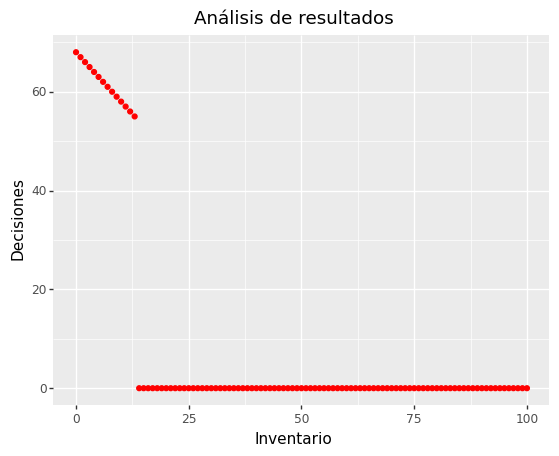

<ggplot: (338035029)>

In [10]:
g0=(
    ggplot(df_0, aes(x='Inventario'))
    + geom_point(aes(y='Decisiones'),color='Red')
    + labs(title="Análisis de resultados",x='Inventario', y='Decisiones')
    )
ggsave(g0, "graficos/g0.pdf")
g0

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: graficos/g0_2.pdf


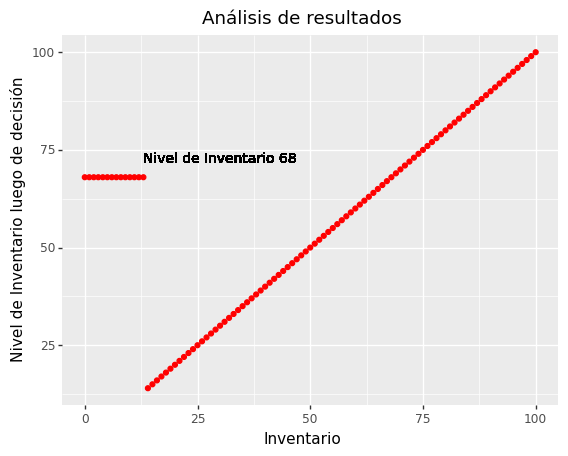

<ggplot: (338741709)>

In [21]:
df_0['n_i_d']=df_0['Inventario']+df_0['Decisiones']
y_punto=df_0['n_i_d'][13]
g0_2=(
    ggplot(df_0, aes(x='Inventario'))
    + geom_point(aes(y='n_i_d'),color='Red')
    + labs(title="Análisis de resultados",x='Inventario', y='Nivel de Inventario luego de decisión')
    + geom_text(aes(x = 30, y = y_punto+5), label = 'Nivel de Inventario '+str(y_punto), color = 'Black', size=10))
ggsave(g0_2, "graficos/g0_2.pdf")
g0_2

# Análisis de Sensibilidad
Las variaciones propuestas son las siguientes:

*  Elevar el costo de compra de las cervezas desde 1 hasta 70.000.
*  Elevar el precio de venta de las cervezas desde precio de compra hasta hasta 10500.
*  Elevar el tamaño del frigobar (S).

Queremos observar como cambia cuanto pedir al variar los costos mencionados anteriormente.

##   Elevar el costo de compra de las cervezas desde 1 hasta 70.000.

In [33]:
D=np.zeros(S+1).astype('int')
prob=matriz_prob(S,prob_uniforme)
S_i=[]
COSTO=[]
for i in range(1,70002,250):
    
    expectet_reward= reward_esperado(prob_uniforme,S,a,b,v,h,c)
    temp=Search_OP(D,prob,tasa,c,expectet_reward,S,i,1)
    Optimo=temp.copy()
    S_i.append(Optimo[0])
    COSTO.append(i)

In [34]:
d_1= {'S':S_i,
    'Costo':COSTO}
df_1=pd.DataFrame.from_dict(d_1)

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: graficos/g1.pdf


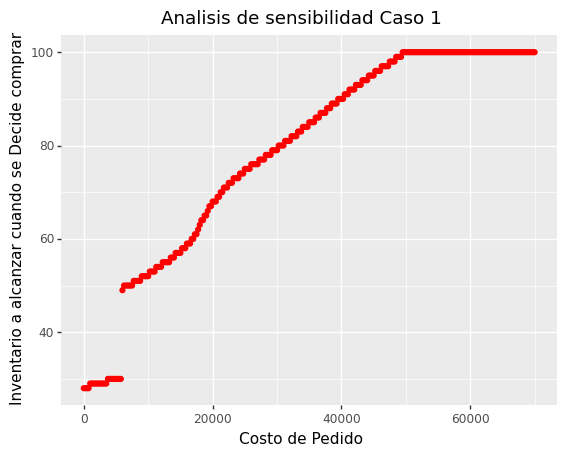

<ggplot: (276822597)>

In [36]:
g1=(
    ggplot(df_1, aes(x='Costo'))
    + geom_point(aes(y='S'),color='Red')
    + labs(title="Analisis de sensibilidad Caso 1",x='Costo de Pedido', y='Inventario a alcanzar cuando se Decide comprar')
    )
ggsave(g1, "graficos/g1.pdf")
g1

## Elevar el precio de venta de las cervezas desde precio de compra hasta hasta 10500.

In [37]:
S=100
S_i=[]
precio_venta=[]
D=np.zeros(S+1).astype('int')
prob=matriz_prob(S,prob_uniforme)
for i in range(300,20501,10):
    
    expectet_reward= reward_esperado(prob_uniforme,S,a,b,i,h,c)
    temp=Search_OP(D,prob,tasa,c,expectet_reward,S,k,1)
    Optimo=temp.copy()
    S_i.append(Optimo[0])
    precio_venta.append(i)

In [38]:
d_2= {'S':S_i,
    'precio_venta':precio_venta}
df_2=pd.DataFrame.from_dict(d_2)

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: graficos/g2.pdf


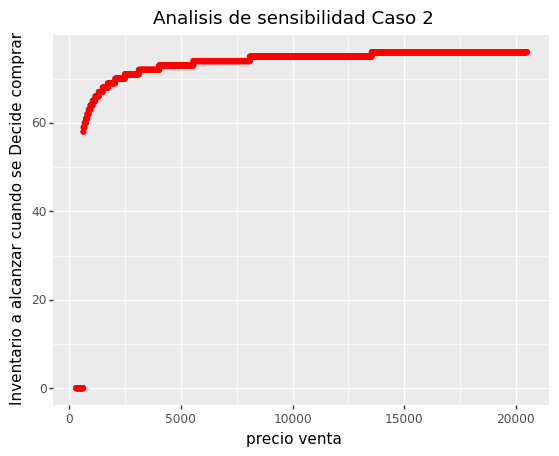

<ggplot: (339766313)>

In [39]:
g2=(
    ggplot(df_2, aes(x='precio_venta'))
    + geom_point(aes(y='S'),color='Red')
    + labs(title="Analisis de sensibilidad Caso 2",x='precio venta', y='Inventario a alcanzar cuando se Decide comprar')
    )
ggsave(g2, "graficos/g2.pdf")
g2

## Cambio tamaño frigobar

In [40]:
S_i=[]
S_size=[]
for i in range(5,201,5):
    D=np.zeros(i+1).astype('int')
    prob=matriz_prob(i,prob_uniforme)
    expectet_reward= reward_esperado(prob_uniforme,i,a,b,v,h,c)
    temp=Search_OP(D,prob,tasa,c,expectet_reward,i,k,1)
    Optimo=temp.copy()
    S_i.append(Optimo[0])
    S_size.append(i)

In [41]:
d_3= {'S':S_i,
    'S_size':S_size}
df_3=pd.DataFrame.from_dict(d_3)

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: graficos/g3.pdf


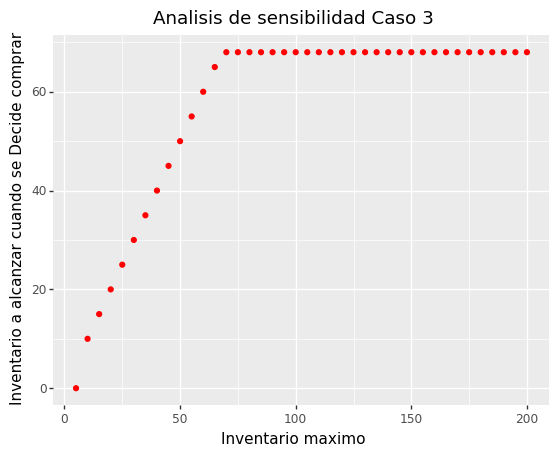

<ggplot: (338363777)>

In [42]:
g3=(
    ggplot(df_3, aes(x='S_size'))
    + geom_point(aes(y='S'),color='Red')
    + labs(title="Analisis de sensibilidad Caso 3",x='Inventario maximo', y='Inventario a alcanzar cuando se Decide comprar')
    )
ggsave(g3, "graficos/g3.pdf")
g3